## Simulación de Intensidad Magnetica Total

### Se utiliza el modulo de campo magnetico potencial de SimPEG para predecir un modelo de susceptibilidad magnetica. Se utilizan datos simulados en una malla de tensores.

In [1]:
#importamos librerias que se van a utilizar
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps
from SimPEG.potential_fields import magnetics

In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41)) #simulamos la topografia superficial mediante una meshgrid
z_topo = -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2) #en base a la topografia superficial simulamos la profundidad
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo) 
xyz_topo = np.c_[x_topo, y_topo, z_topo] #concatenamos la topografia en 3D

#### Definimos la prospección geofisica que se utilizo para conseguir los datos, en este caso como un numpy array

In [3]:
#Definimos las localizaciones de las posiciones de observacion
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-80.0, 80.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)

fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10 
receiver_locations = np.c_[x, y, z]

In [4]:
components = ["tmi"] #Definimos los componentes que queremos simular, en este caso Intensidad Magnetica Total (TMI)

In [5]:
receiver_list = magnetics.receivers.Point(receiver_locations, components=components) #utilizando las posiciones de observación definimos donde se reciben los datos
receiver_list = [receiver_list]

In [6]:
#Definimos los parametros del campo magentico inducido
inclination = 90
declination = 0
strength = 50000
inducing_field = (strength, inclination, declination)

source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

/tmp/ipykernel_666/1716987605.py:7: FutureWarning: SourceField has been deprecated, please use UniformBackgroundField. It will be removed in version 0.19.0 of SimPEG.
  source_field = magnetics.sources.SourceField(


In [7]:
survey = magnetics.survey.Survey(source_field) #Definimos la prospeccion a utilizar

#### Creamos la malla de tensores que vamos a utilizar pora nuestra simulación

In [8]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

#### Definimos el modelo de susceptibilidad magnetica

In [9]:
#Definimos los valores de susceptibilidad magnetica
background_susceptibility = 0.0001
sphere_susceptibility = 0.01

In [10]:
ind_active = active_from_xyz(mesh, xyz_topo) #Buscamos celdas activas en el modelo

In [11]:
#Definimos el mapeo de celdas activas
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

In [12]:
#Definimos el modelo
model = background_susceptibility * np.ones(ind_active.sum())
ind_sphere = model_builder.getIndicesSphere(
    np.r_[0.0, 0.0, -45.0], 15.0, mesh.cell_centers
)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_susceptibility

/tmp/ipykernel_666/4110886576.py:3: FutureWarning: getIndicesSphere has been deprecated, please use get_indices_sphere. It will be removed in version 0.19.0 of SimPEG.
  ind_sphere = model_builder.getIndicesSphere(


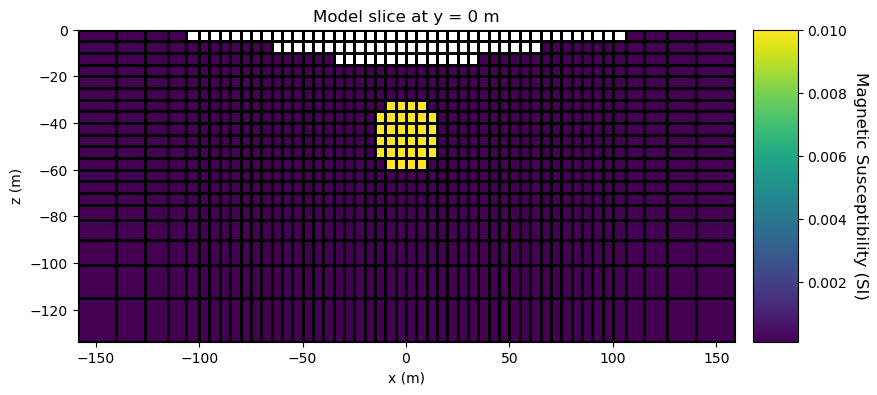

In [13]:
#Ploteamos el modelo
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

plt.show()


### Simulación de intensidad Magnetica Total para un modelo de susceptibilidad

In [14]:
#Definimos la simulación 
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only", #Con el argumento "forward_only" simulamos los datos sin que se guarden las sensitividadaes anteriores
)

In [15]:
#simulamos datos de un modelo de susceptibilidad
dpred = simulation.dpred(model)

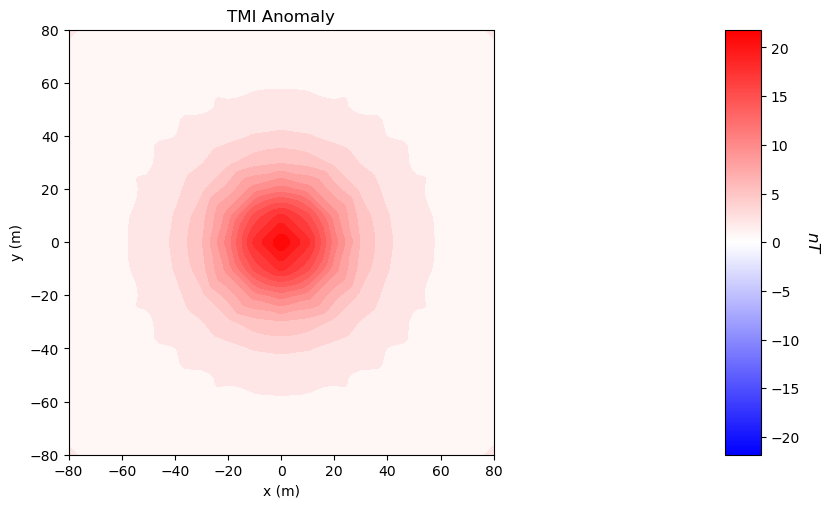

In [16]:
#Ploteamos el modelo
fig = plt.figure(figsize=(12, 5))
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()